In [14]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score #For cross-validation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor

In [15]:
df = pd.read_csv('Advertising.csv')
df.head().T

,0,1,2,3,4
Unnamed: 0,1.0,2.0,3.0,4.0,5.0
TV,230.1,44.5,17.2,151.5,180.8
Radio,37.8,39.3,45.9,41.3,10.8
Newspaper,69.2,45.1,69.3,58.5,58.4
Sales,22.1,10.4,9.3,18.5,12.9


In [16]:
X = df.drop('Sales', axis=1)
y = df['Sales']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [18]:
models = {
    'LinearRegression': LinearRegression(),
    'HuberRegression': HuberRegressor(),
    'PassiveAggressiveRegression': PassiveAggressiveRegressor()
}

In [19]:
# Initialize an empty list to store results
results_list = []

# Loop through models and evaluate their performance
for model_name, model_instance in models.items():
    start_time = time.time()
    model_instance.fit(X_train, y_train)
    
    y_pred = model_instance.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_cv = np.mean(np.sqrt(-cross_val_score(model_instance, X, y, scoring="neg_mean_squared_error", cv=5)))
    
    # Store results in a dictionary format
    results_list.append({
        'Model': model_name, 
        'Run Time': format(round((time.time() - start_time) / 60, 2)), 
        'RMSE': rmse, 
        'RMSE_CV': rmse_cv})

In [20]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results_list)
print(results_df)

                         Model Run Time      RMSE   RMSE_CV
0             LinearRegression      0.0  2.177404  1.737981
1              HuberRegression      0.0  2.255526  1.753490
2  PassiveAggressiveRegression      0.0  2.355533  3.353402


In [21]:
# Select the best model based on criteria
best_model_name = results_df.sort_values(by=['Run Time', 'RMSE', 'RMSE_CV']).iloc[0]['Model']
best_model = models[best_model_name]

In [22]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, 1, 2],
    'positive': [True, False]
}

In [23]:
# Perform GridSearchCV to find the best hyperparameters for the best model
grid_search = GridSearchCV(estimator=best_model, 
                           param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error',
                           cv=10)

In [24]:
# Fit the GridSearchCV with training data
best_model_grid_searched = grid_search.fit(X_train, y_train) 
print('Optimum parameters', best_model_grid_searched.best_params_)

# Initialize a new Linear Regression model with the best parameters found
best_model_final = LinearRegression(copy_X=best_model_grid_searched.best_params_['copy_X'], 
                                    fit_intercept=best_model_grid_searched.best_params_['fit_intercept'],
                                    n_jobs=best_model_grid_searched.best_params_['n_jobs'],
                                    positive=best_model_grid_searched.best_params_['positive'])

# Fit the best model with training data
best_model_final.fit(X_train, y_train)

Optimum parameters {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': True}


LinearRegression(n_jobs=-1, positive=True)

In [25]:
# Make predictions using the best model
y_pred_best = best_model_final.predict(X_test)

# Calculate RMSE for the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
print(f"Best Model RMSE: {rmse_best}")

Best Model RMSE: 2.174029919078997


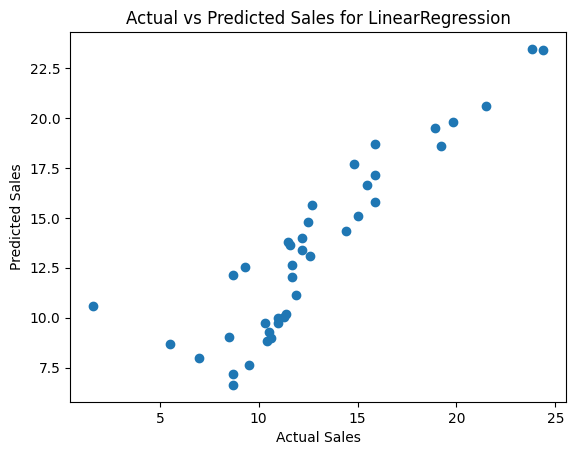

In [26]:

# Plot the performance of the best model
plt.scatter(y_test, y_pred_best)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales for {best_model_name}')
plt.show()